In [38]:
#!pip3.6 install myhdl
#!pip3.6 install myhdlpeek

#

## Python->Verilog->PYNQ FM GEN & Micrphone Signals Anylsis

In [2]:
import numpy as np
import pandas as pd
from IPython.display import display, Math, Latex
from sympy import *
init_printing()
from tabulate import tabulate
import itertools

 
from myhdl import *
from myhdlpeek import Peeker

from random import randrange
import matplotlib.pyplot as plt
%matplotlib inline


# Acknowledgments
The orgianl Chebyshev Sinwave Genrator written in myHDL was done by ["HARDSOFTLUCID"](https://hardsoftlucid.wordpress.com/various-stuff/myhdl/)
(myHDL.old version [here](https://github.com/jandecaluwe/site-myhdl-retired/blob/master/_ori/pages/projects/continuous_wave_sinusgenerator.txt))

Author of myHDL [Jan Decaluwe](http://www.myhdl.org/users/jandecaluwe.html) and the author of the myHDL Peeker [XESS Corp.](https://github.com/xesscorp/myhdlpeek)

And to my Digital Signal Processing Advisor [Dr. Jesse Wilson](http://www.engr.colostate.edu/ece/facultystaff/facultypage.php?pass=146)


# Derivation of the Chebyshev Polynomial Approximation for Sin & Cos

## Chebyshev Polynomials

We Start with recalling that the double(n) angle trig identity for $n=2$ is
 $\cos$ are
$$\cos(2\theta)= \cos(\theta)^2 -\sin(\theta)^2 = 2\cos(\theta)^2 -1$$
and for $n=3$ is 
$$\cos(3\theta)= cos(\theta)^3 -3\sin(\theta)^2 \cos(\theta)=4\cos(\theta)^3 -3\cos(\theta)$$

Now exploiting Chebyshev polynomials that come from the power series solution($y(x)=\sum_{n=0}^{\infty} a_n x^n$) of  Chebyshev differential equation:
$$(1-x^2)y" -xy'+p^2y=0$$

The Power series solution takes on the form of a Recurrence relation for the $a_n$ term in the Power series as
$$a_{n+2}=\dfrac{(n-p)(n+p)}{(n+1)(n+2)}a_n$$
for $x\in [-1, 1]$
that leads to the Chebyshev polynomial defined as
$$T_0(x)=1$$
$$T_1(x)=x$$
$$T_{n+1}(x)=2xT_n(x)-T_{n-1}(x)$$





### Plot of Chebyshev Polynomials

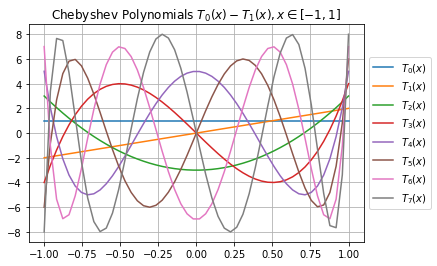

In [3]:
x=np.linspace(-1.0, 1.0)
fig=plt.figure()
ax=plt.subplot(111)
for i in range(1,8+1):
    coeff=[0]*i
    coeff[-1]=i
    y=np.polynomial.Chebyshev(coeff)(x)
    ax.plot(x, y, label=f'$T_{i-1}(x)$')
bbox_to_anchor=ax.get_position()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid()
plt.title(r"Chebyshev Polynomials $T_0(x)-T_1(x), x\in[-1, 1]$" )
None

## Chebyshev Polynomial $\cos$ Representation


If now $T_n(x)=T_n(cos(\theta))=cos(n\theta)$ we have

$$T_0(\cos(\theta))=1$$
$$T_1(\cos(\theta))=\cos(\theta)$$
$$T_{n+1}(\cos(\theta))=2 \cos(\theta)T_n(\cos(\theta))-T_{n-1}(\cos(\theta))$$
$$\cos((n+1)\theta)=2\cos(\theta)\cos(n\theta)-\cos((n-1)\theta)$$

solving for $\cos(\theta)$ we get

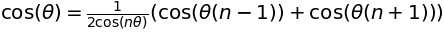

In [4]:
n, theta=symbols('n, theta')
LHS=cos(theta)
RHS=(cos((n+1)*theta)+cos((n-1)*theta))/(2*cos(n*theta))
Eq(LHS, RHS)

In [5]:
f_1, f_2=symbols('f_1, f_2')
simplify((cos(2*pi*(n+1)*(f_1+f_2))+cos(2*pi*(n-1)*(f_1+f_2)))/(2*cos(2*pi*(n)*(f_1+f_2))))

### Plots of Chebyshev polynomial $\cos$ Approx.

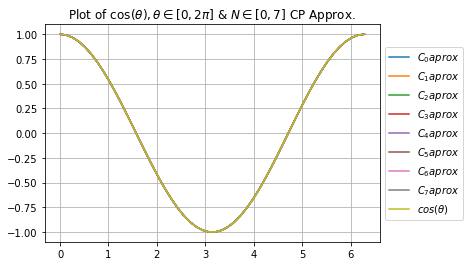

In [6]:
#numericalize symbolic
RHSN=lambdify((n, theta), RHS, dummify=False)

fig=plt.figure()
ax=plt.subplot(111)

thetaN=np.linspace(0, 2*np.pi)
for N in range(1, 8+1):
    y=RHSN(N, thetaN)
    ax.plot(thetaN, y, label=f'$C_{N-1} aprox$')
ax.plot(thetaN, np.cos(thetaN), label=r'$cos(\theta)$')
ax.grid()

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title(r"Plot of $\cos(\theta), \theta \in[0, 2\pi]$ & $N\in[0, 7]$ CP Approx.")
None

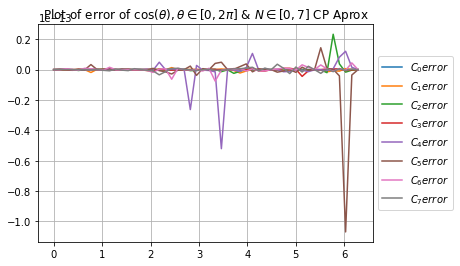

In [7]:
thetaN=np.linspace(0, 2*np.pi)
for N in range(1, 8+1):
    y=np.cos(thetaN)-RHSN(N, thetaN)
    plt.plot(thetaN, y, label=f'$C_{N-1} error$')
plt.grid()
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title(r"Plot of error of $\cos(\theta), \theta \in[0, 2\pi]$ & $N\in[0, 7]$ CP Aprox")

None

## Algorithm Development

now letting $\cos(\theta)=\cos(2*\pi f_{\sin}/f_{clk})=K'(\theta)$ we have
$$K'((n+1)\theta)=2K'(\theta)K'(n\theta)-K'((n-1)\theta)$$

Then letting $2K'=K$ and splitting up the recursion relations we have
$$R_0=K'((n-1)\theta)$$
$$R_2=KR_1-R_0$$
where R now represents a register. We will also have to add a an overflow wrapper via a shift register

In [8]:
def SinGenerator(SinFreq_parm, ClkFreq_parm, SinValue_out, 
                clk, rst, ena):
    #contorl byte size and works with -1 to translate cos to sin
    INTERNALWIDTH=len(SinValue_out)-2 
    
    #qunitited version of the 2x for cos(\theta)
    KONSTANT_FACTOR=int(np.cos(2*np.pi * SinFreq_parm /ClkFreq_parm)* 2**(INTERNALWIDTH))
    
    #prep the Needed regesters at sysnthis 
    Reg_T0=Signal(intbv((2**(INTERNALWIDTH))-1, 
                        min=SinValue_out.min, max=SinValue_out.max))
    Reg_T1=Signal(intbv(KONSTANT_FACTOR, 
                        min=SinValue_out.min, max=SinValue_out.max))
    
    #define the polynomal logic
    @always(clk.posedge,rst.negedge)
    def logicCP():
        #clear and prep the regesters
        if rst== 0 :
            Reg_T0.next=(2**(INTERNALWIDTH))-1
            Reg_T1.next=KONSTANT_FACTOR
        
        #run a single recursion iterration of the polynomal
        else:
            if ena==1:
                # recursive Chebyshev  formulation for sinus waveform calculation
                Reg_T0.next=Reg_T1
                #>> shift is a overflow wrapper
                Reg_T1.next=((KONSTANT_FACTOR * Reg_T1)>>(INTERNALWIDTH-1)) - Reg_T0
    
    #pole the R1 for the value of the sin function
    @always_comb
    def comb_logic():
        SinValue_out.next=Reg_T1
  
    return instances()

# Test Bench for $\sin$ Generator

In [9]:
SinFreq=0.75e6   # make a 1.45 mhz Sinus
clkFreq=10e6   # 10 mhz
clkPeriod=1.0/clkFreq

OUTPUT_BITWIDTH=30

Peeker.clear()

SinValue_out=Signal(intbv(0, min=-2**OUTPUT_BITWIDTH, max=2**OUTPUT_BITWIDTH))
Peeker(SinValue_out, 'SinVal')
SinValueTracker=[]

clk=Signal(bool(0)); Peeker(clk, 'clk')
ena=Signal(bool(0)); Peeker(ena, 'ena')
rst=Signal(bool(0)); Peeker(rst, 'rst')

DUT=SinGenerator(SinFreq_parm=SinFreq, ClkFreq_parm=clkFreq, SinValue_out=SinValue_out, 
                clk=clk, rst=rst, ena=ena)


def SinGenerator_TB(TestClkCyc=200):
  
    
    
    #clock genrator
    @always(delay(int(clkPeriod*0.5*1e9)))  ## delay in nano seconds
    def clkGen():
        clk.next = not clk
    
    # accterla test procdure
    @instance
    def stimulus(): 
        while 1:
            rst.next=0
            ena.next=0
            #wait one clock cycle
            yield clk.posedge
            
            #test reset
            rst.next=1
            
            #wait one clock cycle
            yield clk.posedge
            
            #run the sin wave genrator
            ena.next=1
            #run the test for 200 clock cycles
            for i in range(TestClkCyc):
                #wait for next clock cycle
                yield clk.posedge
                SinValueTracker.append(int(SinValue_out))
            raise StopSimulation


    return instances()

!? Peeker is failing for some reason to capture all these values so haveing to improve

In [10]:
N=200
sim = Simulation(DUT, SinGenerator_TB(TestClkCyc=N), *Peeker.instances()).run()
#Peeker.to_wavedrom(start_time=0, stop_time=20, tock=True)

# Post Processing of Test Bench

In [11]:
SinGenOutDF=pd.DataFrame(columns=['SinValue'], data=SinValueTracker)
SinGenOutDF['Time[s]']=np.arange(0.0,clkPeriod*(len(SinGenOutDF)-0.5),clkPeriod)
SinGenOutDF['SinValueNorm']=SinGenOutDF['SinValue']/SinGenOutDF['SinValue'].max()
SinGenOutDF['f[Hz]']=np.arange(-clkFreq/2.0,clkFreq/2.0,clkFreq/(len(SinValueTracker)))

FFT=np.fft.fftshift(np.fft.fft(SinGenOutDF['SinValueNorm']))
SinGenOutDF['FFTMag']=np.abs(FFT)
SinGenOutDF['FFTPhase']=np.angle(FFT)
SinGenOutDF.head(5)

,SinValue,Time[s],SinValueNorm,f[Hz],FFTMag,FFTPhase
0,478355485,0.000000e+00,0.891007,-5000000.0,1.676381e-08,-5.921190e-15
1,315564804,1.000000e-07,0.587785,-4950000.0,1.169079e-08,8.481712e-02
2,83985113,2.000000e-07,0.156434,-4900000.0,1.374530e-08,-2.588747e-02
3,-165902237,3.000000e-07,-0.309017,-4850000.0,1.256693e-08,8.504632e-03
4,-379625064,4.000000e-07,-0.707107,-4800000.0,1.237123e-08,3.107669e-01


In [14]:
CosDF=pd.DataFrame(columns=['Time[s]'], data=np.arange(0.0,clkPeriod*(len(SinGenOutDF)-0.5),clkPeriod))
CosDF['Sin']=np.cos(2*np.pi*SinFreq*SinDF['Time[s]'])
CosDF['SinS']=CosDF['Sin']*SinGenOutDF['SinValue'].max()
CosDF['f[Hz]']=np.arange(-clkFreq/2.0,clkFreq/2.0,clkFreq/(len(SinValueTracker)))
FFT=np.fft.fftshift(np.fft.fft(CosDF['Sin']))
CosDF['FFTMag']=np.abs(FFT)
CosDF['FFTPhase']=np.angle(FFT)
CosDF.head(5)

,Time[s],Sin,SinS,f[Hz],FFTMag,FFTPhase
0,0.000000e+00,1.000000,5.368709e+08,-5000000.0,4.768857e-15,-3.141593
1,1.000000e-07,0.891007,4.783555e+08,-4950000.0,3.754675e-14,-1.502735
2,2.000000e-07,0.587785,3.155648e+08,-4900000.0,3.920159e-14,0.642098
3,3.000000e-07,0.156434,8.398512e+07,-4850000.0,4.962420e-14,-0.653919
4,4.000000e-07,-0.309017,-1.659022e+08,-4800000.0,9.565805e-14,1.207279


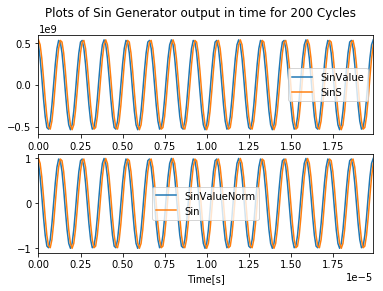

In [17]:
fig, [ax0, ax1]=plt.subplots(nrows=2, ncols=1, sharex=False)
plt.suptitle(f'Plots of Sin Generator output in time for {N} Cycles')

SinGenOutDF.plot(use_index=True ,y='SinValue', ax=ax0)
CosDF.plot(use_index=True, y='SinS', ax=ax0)
ax0.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax0.legend(loc='best')

SinGenOutDF.plot(x='Time[s]', y='SinValueNorm', ax=ax1)
CosDF.plot(x='Time[s]', y='Sin', ax=ax1)
ax1.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax1.legend(loc='best')

None

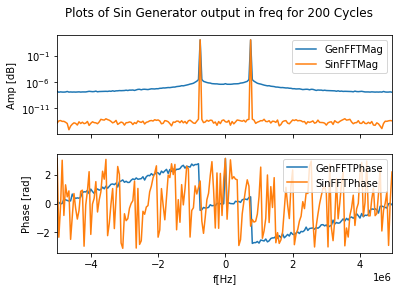

In [18]:
fig, [ax0, ax1]=plt.subplots(nrows=2, ncols=1, sharex=True)
plt.suptitle(f'Plots of Sin Generator output in freq for {N} Cycles')

SinGenOutDF.plot(x='f[Hz]' ,y='FFTMag', logy=True, ax=ax0, label='GenFFTMag')
SinDF.plot(x='f[Hz]' ,y='FFTMag', logy=True, ax=ax0, label='SinFFTMag')

ax0.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax0.set_ylabel('Amp [dB]')
ax0.legend(loc='best')

SinGenOutDF.plot(x='f[Hz]', y='FFTPhase', ax=ax1, label='GenFFTPhase')
SinDF.plot(x='f[Hz]', y='FFTPhase', ax=ax1, label='SinFFTPhase')
ax1.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax1.set_xlabel('f[Hz]'); ax1.set_ylabel('Phase [rad]')

ax1.legend(loc='best')

None

# Modification for Frequncy Control

In [19]:
def SinGeneratorFMOD(SinFreq_parm, ClkFreq_parm, KONSTANT_FACTOR_in,  SinValue_out, 
                clk, rst):
    #contorl byte size and works with -1 to translate cos to sin
    INTERNALWIDTH=len(SinValue_out)-2 
    
    #qunitited version of the 2x for cos(\theta)
    KONSTANT_FACTOR=int(np.cos(2*np.pi * SinFreq_parm /ClkFreq_parm)* 2**(INTERNALWIDTH))
    
    #prep the Needed regesters at sysnthis 
    Reg_T0=Signal(intbv((2**(INTERNALWIDTH))-1, 
                        min=SinValue_out.min, max=SinValue_out.max))
    Reg_T1=Signal(intbv(KONSTANT_FACTOR, 
                        min=SinValue_out.min, max=SinValue_out.max))
    
    #define the polynomal logic
    @always(clk.posedge,rst.negedge)
    def logicCP():
        #clear and prep the regesters
        if rst== 0 :
            Reg_T0.next=(2**(INTERNALWIDTH))-1
            Reg_T1.next=KONSTANT_FACTOR
        
        #run a single recursion iterration of the polynomal
        else:
            # recursive Chebyshev  formulation for sinus waveform calculation
            Reg_T0.next=Reg_T1
            #>> shift is a overflow wrapper
            Reg_T1.next=((KONSTANT_FACTOR_in * Reg_T1)>>(INTERNALWIDTH-1)) - Reg_T0

    #pole the R1 for the value of the sin function
    @always_comb
    def comb_logic():
        SinValue_out.next=Reg_T1
  
    return instances()

In [24]:
SinFreq=0.75e6   # make a 1.45 mhz Sinus
clkFreq=10e6   # 10 mhz
clkPeriod=1.0/clkFreq

OUTPUT_BITWIDTH=30

Peeker.clear()

SinValue_out=Signal(intbv(0, min=-2**OUTPUT_BITWIDTH, max=2**OUTPUT_BITWIDTH))
New_KONSTANT_FACTOR_in=lambda SinFreq: int(np.cos(2*np.pi * SinFreq /clkFreq)* 2**(len(SinValue_out)-2 ))

KONSTANT_FACTOR_in=Signal(intbv(New_KONSTANT_FACTOR_in(SinFreq), min=-2**OUTPUT_BITWIDTH, max=2**OUTPUT_BITWIDTH))

Peeker(SinValue_out, 'SinVal')
SinValueTracker=[]

clk=Signal(bool(0)); Peeker(clk, 'clk')
rst=Signal(bool(0)); Peeker(rst, 'rst')

DUT=SinGeneratorFMOD(SinFreq_parm=SinFreq, ClkFreq_parm=clkFreq, KONSTANT_FACTOR_in=KONSTANT_FACTOR_in,  SinValue_out=SinValue_out,
                clk=clk, rst=rst)


def SinGeneratorFMOD_TB(TestClkCyc=200):
  
    
    
    #clock genrator
    @always(delay(int(clkPeriod*0.5*1e9)))  ## delay in nano seconds
    def clkGen():
        clk.next = not clk
    
    # accterla test procdure
    @instance
    def stimulus(): 
        while 1:
            rst.next=0
            #wait one clock cycle
            yield clk.posedge
            
            #test reset
            rst.next=1
            
            #wait one clock cycle
            yield clk.posedge
            
            #run the sin wave genrator
            #run the test for 200 clock cycles
            for i in range(TestClkCyc//2):
                #wait for next clock cycle
                yield clk.posedge
                SinValueTracker.append(int(SinValue_out))
            
            KONSTANT_FACTOR_in.next=New_KONSTANT_FACTOR_in(2*SinFreq)
            for i in range(TestClkCyc//2):
                yield clk.posedge
                SinValueTracker.append(int(SinValue_out))
            raise StopSimulation


    return instances()

In [25]:
N=400
sim = Simulation(DUT, SinGeneratorFMOD_TB(TestClkCyc=N), *Peeker.instances()).run()
#Peeker.to_wavedrom(start_time=0, stop_time=20, tock=True)

## Post Processing of FMOD Test Bench

In [26]:
SinGenOutDF=pd.DataFrame(columns=['SinValue'], data=SinValueTracker)
SinGenOutDF['Time[s]']=np.arange(0.0,clkPeriod*(len(SinGenOutDF)-0.5),clkPeriod)
SinGenOutDF['SinValueNorm']=SinGenOutDF['SinValue']/SinGenOutDF['SinValue'].max()
SinGenOutDF['f[Hz]']=np.arange(-clkFreq/2.0,clkFreq/2.0,clkFreq/(len(SinValueTracker)))

FFT=np.fft.fftshift(np.fft.fft(SinGenOutDF['SinValueNorm']))
SinGenOutDF['FFTMag']=np.abs(FFT)
SinGenOutDF['FFTPhase']=np.angle(FFT)
#SinGenOutDF

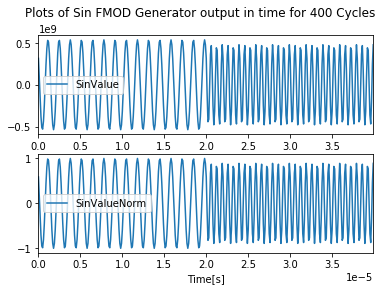

In [27]:
fig, [ax0, ax1]=plt.subplots(nrows=2, ncols=1, sharex=False)
plt.suptitle(f'Plots of Sin FMOD Generator output in time for {N} Cycles')

SinGenOutDF.plot(use_index=True ,y='SinValue', ax=ax0)
ax0.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax0.legend(loc='best')

SinGenOutDF.plot(x='Time[s]', y='SinValueNorm', ax=ax1)
ax1.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax1.legend(loc='best')

None

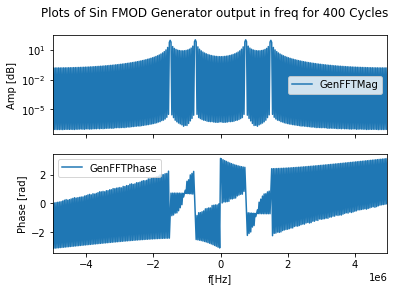

In [28]:
fig, [ax0, ax1]=plt.subplots(nrows=2, ncols=1, sharex=True)
plt.suptitle(f'Plots of Sin FMOD Generator output in freq for {N} Cycles')

SinGenOutDF.plot(x='f[Hz]' ,y='FFTMag', logy=True, ax=ax0, label='GenFFTMag')

ax0.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax0.set_ylabel('Amp [dB]')
ax0.legend(loc='best')

SinGenOutDF.plot(x='f[Hz]', y='FFTPhase', ax=ax1, label='GenFFTPhase')
ax1.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax1.set_xlabel('f[Hz]'); ax1.set_ylabel('Phase [rad]')

ax1.legend(loc='best')

None

# RTL Synthisis

In [29]:
SinFreq=0.75e6   # make a 1.45 mhz Sinus
clkFreq=10e6   # 10 mhz
clkPeriod=1.0/clkFreq

OUTPUT_BITWIDTH=30

Peeker.clear()

SinValue_out=Signal(intbv(0, min=-2**OUTPUT_BITWIDTH, max=2**OUTPUT_BITWIDTH))
KONSTANT_FACTOR_in=Signal(intbv(New_KONSTANT_FACTOR_in(SinFreq), min=-2**OUTPUT_BITWIDTH, max=2**OUTPUT_BITWIDTH))


clk=Signal(bool(0))
ena=Signal(bool(0))
rst=Signal(bool(0))

#toVerilog(SinGenerator, SinFreq, clkFreq, SinValue_out, clk, rst, ena)
toVerilog(SinGeneratorFMOD, SinFreq, clkFreq, KONSTANT_FACTOR_in, SinValue_out, clk, rst)


In [30]:
def VerilogTextReader(loc, printresult=True):
    with open(f'{loc}.v', 'r') as vText:
        VerilogText=vText.read()
    if printresult:
        print(f'***Verilog modual from {loc}.v***\n\n', VerilogText)
    return VerilogText

def VHDLTextReader(loc, printresult=True):
    with open(f'{loc}.vhd', 'r') as vText:
        VerilogText=vText.read()
    if printresult:
        print(f'***VHDL modual from {loc}.vhd***\n\n', VerilogText)
    return VerilogText

In [31]:
_=VerilogTextReader('SinGeneratorFMOD', True)

***Verilog modual from SinGeneratorFMOD.v***

 // File: SinGeneratorFMOD.v
// Generated by MyHDL 0.9.0
// Date: Sat Oct  7 16:52:25 2017


`timescale 1ns/10ps

module SinGeneratorFMOD (
    KONSTANT_FACTOR_in,
    SinValue_out,
    clk,
    rst
);


input signed [30:0] KONSTANT_FACTOR_in;
output signed [30:0] SinValue_out;
wire signed [30:0] SinValue_out;
input clk;
input rst;

reg signed [30:0] Reg_T1;
reg signed [30:0] Reg_T0;






assign SinValue_out = Reg_T1;


always @(posedge clk, negedge rst) begin: SINGENERATORFMOD_LOGICCP
    if ((rst == 0)) begin
        Reg_T0 <= ((2 ** 29) - 1);
        Reg_T1 <= 478355485;
    end
    else begin
        Reg_T0 <= Reg_T1;
        Reg_T1 <= ($signed((KONSTANT_FACTOR_in * Reg_T1) >>> (29 - 1)) - Reg_T0);
    end
end

endmodule



The RTL Schematic from the verilog myHDL synthesis via vavado 2016.1 of the Sine Generator (NON FM) is shown below
<img style="float: center;" src="SinGenRTL.PNG">

The RTL Synthesis shows 65 cells, 34 I/O ports 161 Nets, 2 Register Sets, and 3 RTL Operations (multiply, right shift, subtraction). Where the last two statistics are exactly as predected from the myHDL (python) function **SinGenerator** 

# Refrances

https://en.wikibooks.org/wiki/Trigonometry/For_Enthusiasts/Chebyshev_Polynomials

https://www.geophysik.uni-muenchen.de/~igel/Lectures/NMG/05_orthogonalfunctions.pdf

# Pulse Density Modulation
via https://www.koheron.com/blog/2016/09/27/pulse-density-modulation

In [32]:
def pdm(x):
    n = len(x)
    y = np.zeros(n)
    error = np.zeros(n+1)    
    for i in range(n):
        y[i] = 1 if x[i] >= error[i] else 0
        error[i+1] = y[i] - x[i] + error[i]
    return y, error[0:n]

In [33]:
y, error=pdm(SinGenOutDF['SinValue'])
t=SinGenOutDF['Time[s]']

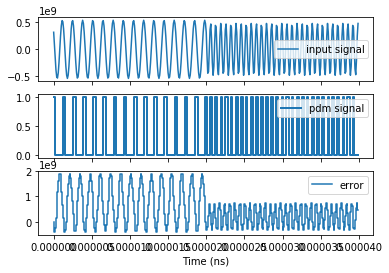

In [37]:
fig, [ax1, ax2, ax3]=plt.subplots(nrows=3, ncols=1, sharex=True)
ax1.plot(t, SinGenOutDF['SinValue'], label='input signal')
ax1.legend(loc='best')
ax2.step(t, y, label='pdm signal',  linewidth=2.0)
ax2.legend(loc='best')

ax3.step(t, error, label='error')
ax3.legend(loc='best')

ax3.set_xlabel('Time (ns)')
None

## Kheron's Verilog code for PDM (not MyHDL)

// Pulse density Modulator verilog 
`timescale 1 ns / 1 ps

module pdm #(parameter NBITS = 10)
(
  input wire                      clk,
  input wire [NBITS-1:0]          din,
  input wire                      rst,
  output reg                      dout,
  output reg [NBITS-1:0]          error
);

  localparam integer MAX = 2**NBITS - 1;
  reg [NBITS-1:0] din_reg;
  reg [NBITS-1:0] error_0;
  reg [NBITS-1:0] error_1;

  always @(posedge clk) begin
    din_reg <= din;
    error_1 <= error + MAX - din_reg;
    error_0 <= error - din_reg;
  end

  always @(posedge clk) begin
    if (rst == 1'b1) begin
      dout <= 0;
      error <= 0;
    end
    else if (din_reg >= error) begin
      dout <= 1;
      error <= error_1;
    end else begin
      dout <= 0;
      error <= error_0;
    end
  end

endmodule

## RTL of PDM
taken from https://www.koheron.com/blog/2016/09/27/pulse-density-modulation (I am haveing all sorts of computer issues)

<img style="float: right;" src="PDM_RTL.PNG">

# Base Overlay Modification (DID GET NOT WORKING)

<img style="float: right;" src="PYNQ_baseModefy.PNG">

# Controling Sin Freq and Watch PDM Error(DID NOT GET WORKING)

In [43]:
#from pynq.overlays.mybase import MyBaseOverlay
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
clkFreq=10e6   # 10 mhz
BaseFreq=0.75e6   # make a 1.45 mhz Sinus

class Sin_mit_FM():#MyBaseOverlay):
    def __init__(self, bitfile_name, clkFreq=10e6, BaseFreq=0.75e6, Bitwidth=30, Test=True):
        #super().__init__(bitfile_name)
        
        self.clkFreq=clkFreq
        self.BaseFreq=BaseFreq
        self.Bitwidth=Bitwidth
        
        self.Test=Test
        
        self.New_KONSTANT_FACTOR_in(scale=1)

        self.PDMError=0


        
    def New_KONSTANT_FACTOR_in(self, scale):
        self.scale=scale
        self.Kvalue=int(np.cos(2*np.pi * self.BaseFreq* scale /self.clkFreq)* 2**(self.Bitwidth-2 ))
        if not self.Test:
            self.SendReadUpdateToPYNQ()
    
    def PlotCosTheory(self, scale):
        self.New_KONSTANT_FACTOR_in(scale)
        if not self.Test:
            self.SendReadUpdateToPYNQ()
        
        timespace=np.linspace(0, 1/self.BaseFreq, 100)
        plt.title('CosTheory')
        plt.plot(timespace, np.cos(2*np.pi*self.scale*self.BaseFreq*timespace),
                label=f'PDM Out Error is {self.PDMError}')
        plt.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        plt.xlabel('time'); plt.ylabel('Amp')
        plt.legend(loc='best')
        
    def SendReadUpdateToPYNQ(self):
        #Could Not Get Working
        #self.mmioSinGen.write(0, self.Kvalue|0x80000000) 
        #self.PDMError=self.mmioPDMError.read(0)
        pass
    
        

## What the overlay was supposed to do
The frequency would be scaled from the base frequency effectively creating a user controlled frequency modulator. So that the plot would show the ideal output for the current frequency scaling before the PDM and speaker output, where the PDM error is read in from the PDM module in the FPGA for reference of the sudo DAC error. Where then the speaker output is picked up by the onboard  microphone  that is processed by in High level PYNQ Python interaction.

In [44]:
Test=Sin_mit_FM('mybase.bit', Test=True)
widgets.interact_manual (Test.PlotCosTheory, scale=(0.1, 2.0, 0.1))
None

A Jupyter Widget